# Introduction
This notebook is intended to demonstrate some simple applications of Bayesian Model Selection in astronomy using python, and will also set out some problems for attendees to solve. Please bear in mind that that these examples and problems all implicitly or explicitly assume Bayesian approaches, so I recommend you remind yourselves of the basic principles first. It also assumes some knowledge from the previous lecture/examples on MCMC.

The text and graphical elements of this work is licensed under Attribution 4.0 International. To view a copy of this license, visit http://creativecommons.org/licenses/by/4.0/. The code elements of this notebook are licensed under the MIT license (text at end).

# Some resources
You can find the slides for the lectures here. In addition to the slides, here is a reminder of some general resources that will be useful:

*   David Hogg's "lecture notes"
    * [Fitting a model to data](https://arxiv.org/abs/1008.4686)
    * [Probability calculus for inference](https://arxiv.org/abs/1205.4446)
    * [Using Markov Chain Monte Carlo](https://arxiv.org/abs/1710.06068)
    * [Products of multivariate Gaussians in Bayesian inferences](https://arxiv.org/abs/2005.14199)
*   [*emcee* tutorials](https://emcee.readthedocs.io/en/stable/tutorials/line/)
*   [The MCMC interactive gallery](https://chi-feng.github.io/mcmc-demo/app.html) is a great way to visualise how various MCMC implementations explore parameter space
* A [list of python MCMC packages](https://github.com/Gabriel-p/pythonMCMC)
* Johannes Buchner's [minimal statistics checklist and learning material](https://astrost.at/istics/minimal-statistics-checklist.html)
* Andrae et al (2010) a and b - discussing Error Estimation (key for defining Credible Intervals) and how *not* to use chi-squared statistics.


# This problem set
This will cover a number of examples, including
1.   Calculating different test statistics with python
      1. LRT
      2. AIC
      3. BIC
      4. Bayes' factors
2.   A short example of Nested Sampling for Bayes' factors
3.   Mixture model introduction
      1. Example 1: Outlier rejection
      2. Example 2: Gaussian mixture model for classifying by colour

It will then go on to describe a set of problems with differing levels of difficulty and work to do.  These include
1.   Fitting a line to data:
     1.   with underestimated uncertainties;
     2.   with uncertainties on both dependent and independent variabiles;
     3.   with intrinsic scatter;
     4.   in higher dimensions;
     5.   with non-Gaussian likelihoods;
2.   Checking convergence
3.   Posterior predictive checks
4.   Nuisance parameters
5.   Prior sensitivity

For the most part, these problems are setup in *dynesty* but you are encouraged to try out other python packages based on other MCMC approaches.

#Calculating test statistics in python

There are a lot of codes available to calculate useful test statistics in python. However, for completeness here we include some functions to calculate the Likelihood ratio, Akaike information criterion and Bayesian information criterion.

In [ ]:
from scipy.stats.distributions import chi2
def likelihood_ratio(mll_null, mll_alt, n_null = None, n_alt = None):
    lr = (2*(mll_null-mll_alt))
    if (n_null is not None) and (n_alt is not None):
      p = chi2.sf(lr, np.abs(n_null - n_alt))
      return lr, p
    return lr

def aic(mll, npars):
  return (2 * npars) - (2 * mll)

def bic(mll, npars, npoints):
  return (npars*np.log(npoints)) - (2 * mll)

However, the Bayes Factor is more difficult to calculate immediately, as it involves calculating the evidences of the models.

In [ ]:
def bayesfac(evidence_null, evidence_alt, log=True):
  if log:
    return evidence_null - evidence_alt
  return evidence_null / evidence_alt

# Using Nested Sampling to calculate the evidence

Calculating the evidence is hard, because it involves integrating the likelihood over the entire parameter space. If the entire likelihood can be evaluated and integrated analytically, this is feasible, but a likelihood function doesn't have to get very complex before this is unrealistic or even impossible; this is common in typical astronomical applications. 

For these cases, we turn to special integration routines, and Nested Sampling is a very clever algorithm designed with this specific case in mind. The basic idea is to draw Monte Carlo samples from the prior and evaluate the likelihood at those points, then gradually shrink the sampling volume by moving to higher-likelihood locations. By doing this it integrates the function, naturally producing the evidence. The first step to calculating Bayes factors is therefore to fit the data with Nested Sampling using each model being tested.

There are several python packages available for Nested Sampling, that mostly operate along the same lines as *emcee* treats MCMC. In the following cell we use the package dynesty to fit two models to some data (this will be familiar for everyone who has worked on the problems for the MCMC lecture).

In [ ]:
import numpy as np
from scipy.stats import norm

x = np.array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96969697,
        7.07070707,  7.17171717,  7.27272727,  7.37373737,  7.47474747,
        7.57575758,  7.67676768,  7.77777778,  7.87878788,  7.97979798,
        8.08080808,  8.18181818,  8.28282828,  8.38383838,  8.48484848,
        8.58585859,  8.68686869,  8.78787879,  8.88888889,  8.98989899,
        9.09090909,  9.19191919,  9.29292929,  9.39393939,  9.49494949,
        9.5959596 ,  9.6969697 ,  9.7979798 ,  9.8989899 , 10.        ])
y = np.array([0.60614598, 0.6153662 , 0.47419432, 0.64142881, 0.5404495 ,
       0.65958241, 0.5388796 , 0.72837078, 0.56604171, 0.86397498,
       0.4751028 , 0.4119352 , 0.53598582, 1.04707218, 0.83268879,
       0.65939936, 0.71741511, 0.79977691, 0.76297566, 0.56573409,
       0.68881211, 0.93441395, 1.08102487, 1.06692672, 0.91861211,
       1.14857326, 0.98065209, 0.99522437, 0.98278417, 1.11751265,
       0.79828341, 0.18980406, 1.11795621, 1.16912414, 1.08937796,
       1.05315588, 0.95460981, 1.35636458, 1.5210485 , 1.70122012,
       1.8312029 , 2.50786172, 2.80173261, 3.10481785, 2.62385979,
       2.20492704, 1.6121115 , 1.64443925, 1.69162613, 0.96340852,
       0.86319356, 0.61203334, 0.87827908, 0.73654364, 0.99289407,
       0.74860198, 0.5520727 , 0.74797704, 0.60877654, 0.48734763,
       0.41548919, 0.47134843, 0.65060695, 0.55424859, 0.53872972,
       0.42004391, 0.50261679, 0.41800777, 0.14338189, 0.39985653,
       0.34840721, 0.37024026, 0.57578898, 0.16391488, 0.36135355,
       0.36556374, 0.72052741, 0.49379491, 0.58735107, 0.24443858,
       0.44170883, 0.498692  , 0.51745757, 0.45058975, 0.25297367,
       0.57483966, 0.29939929, 0.5941698 , 0.35649874, 0.56844186,
       0.45872986, 0.36447514, 0.52903476, 0.51461255, 0.70671988,
       0.36093269, 0.63303675, 0.76049668, 1.0671897 , 0.58650049])
yerr = np.array([0.13571468, 0.17649925, 0.2427158 , 0.19674616, 0.1374289 ,
       0.13734713, 0.23344185, 0.13494697, 0.16865474, 0.14877157,
       0.1523842 , 0.21276768, 0.21248585, 0.23104686, 0.2186303 ,
       0.16633297, 0.12466968, 0.19250511, 0.23896049, 0.24204692,
       0.11889055, 0.20328089, 0.19548629, 0.1582987 , 0.18590566,
       0.24759034, 0.23386036, 0.14216423, 0.18593009, 0.2357429 ,
       0.21747414, 0.24222248, 0.17103163, 0.1992606 , 0.15450062,
       0.22667307, 0.23436873, 0.11204839, 0.11259136, 0.11087712,
       0.23634978, 0.17765576, 0.24790074, 0.15669243, 0.1050639 ,
       0.11204431, 0.13651244, 0.14456857, 0.24083602, 0.21794055,
       0.18097375, 0.13599461, 0.23872987, 0.10324854, 0.24533545,
       0.12294229, 0.16149936, 0.10591347, 0.21025653, 0.18675912,
       0.16242686, 0.16716389, 0.18856679, 0.11728497, 0.11803215,
       0.15240304, 0.12481872, 0.17082965, 0.24074905, 0.13743163,
       0.23039399, 0.21941084, 0.24978922, 0.19685753, 0.16923487,
       0.22468505, 0.18220194, 0.10126559, 0.16738149, 0.13034307,
       0.16072441, 0.12061447, 0.15581466, 0.18634505, 0.21928294,
       0.12790317, 0.21768046, 0.15576875, 0.19392913, 0.10682687,
       0.18502616, 0.17874781, 0.1710912 , 0.12937686, 0.20394657,
       0.13313035, 0.10067853, 0.24100547, 0.18669291, 0.19211422])


def model1(x, centre, width, int_intens, baseline):
  #A model for a spectral line described by a gaussian, normalised by integrated intensity
  return int_intens*norm.pdf(x, centre, width) + baseline

def model2(x, centre, width, int_intens, baseline):
  #A model for a spectral line described by a gaussian, normalised by integrated intensity
  #however, now the baseline is more complex
  bl = baseline[0] + baseline[1]*np.sin(baseline[2]*x)
  mod = int_intens*norm.pdf(x, centre, width) + bl
  return mod

def ptform1(u):
  theta = u.copy()
  # now we go over each parameter and transform from U[0, 1) to our desired prior
  lo = -10
  hi = 10
  theta[0] = u[0] * (hi - lo) + lo

  lo = 0
  hi = 100
  theta[1] = u[1] * (hi - lo) + lo

  lo = 0
  hi = 3
  theta[2] = u[2] * (hi - lo) + lo

  lo = -10
  hi = 10
  theta[3] = u[3] * (hi - lo) + lo

  return theta

def ptform2(u):
  theta = u.copy()
  # now we go over each parameter and transform from U[0, 1) to our desired prior
  lo = -10
  hi = 10
  theta[0] = u[0] * (hi - lo) + lo

  lo = 0
  hi = 100
  theta[1] = u[1] * (hi - lo) + lo

  lo = 0
  hi = 3
  theta[2] = u[2] * (hi - lo) + lo

  lo = -2
  hi = 2
  theta[3] = u[3] * (hi - lo) + lo

  lo = -1
  hi = 1
  theta[4] = u[4] * (hi - lo) + lo

  lo = -2
  hi = 2
  theta[5] = u[5] * (hi - lo) + lo
  return theta

def lnlike1(theta, x, y, yerr):
  centre, width, int_intens, baseline = theta
  y_model = model1(x, centre, width, int_intens, baseline)
  like = -0.5 * (((y_model - y)/yerr)**2).sum()
  return like


def lnlike2(theta, x, y, yerr):
  centre = theta[0]
  width = theta[1]
  int_intens = theta[2] 
  baseline = theta[3:]
  y_model = model2(x, centre, width, int_intens, baseline)
  like = -0.5 * (((y_model - y)/yerr)**2).sum()
  return like

try:
  import dynesty
except ImportError:
  !pip install dynesty
  import dynesty

sampler1 = dynesty.NestedSampler(lnlike1, ptform1, 
                                ndim = 4, nlive=1500, logl_args=(x,y,yerr))
sampler1.run_nested(dlogz = 0.01) #Model1 is very simple, so this is extremely fast

results1 = sampler1.results

     |████████████████████████████████| 92kB 3.6MB/s 


42563it [01:16, 557.54it/s, +1500 | bound: 50 | nc: 1 | ncall: 165937 | eff(%): 26.554 | loglstar:   -inf < -84.427 <    inf | logz: -108.183 +/-  0.171 | dlogz:  0.000 >  0.010]


In [ ]:
sampler2 = dynesty.NestedSampler(lnlike2, ptform2, 
                                ndim = 6, nlive=1500, logl_args=(x,y,yerr))
sampler2.run_nested(dlogz = 0.01) #However, model 2 is rather more complex, so this takes ~10 minutes.

results2 = sampler2.results

49431it [07:30, 109.77it/s, +1500 | bound: 144 | nc: 1 | ncall: 381827 | eff(%): 13.339 | loglstar:   -inf < -48.694 <    inf | logz: -77.029 +/-  0.184 | dlogz:  0.000 >  0.010]


These nested sampling runs have given us samples from the posterior and likelihood, estimates of the evidence. We can use these to estimate some of the test statistics coded above. First, we have to extract the maximum likelihood and evidence from the results objects.

In [ ]:
mll1 = np.max(results1['logl'])
ev1 = results1['logz'][-1]

mll2 = np.max(results2['logl'])
ev2 = results2['logz'][-1]

aic1 = aic(mll1, 4)
bic1 = bic(mll1, 4, len(x))
aic2 = aic(mll2, 6)
bic2 = bic(mll2, 6, len(x))

print("AIC - Model 1: ",aic1,"; Model 2: ", aic2," Delta AIC: ", aic1 - aic2) # "; odds of model 2: ", np.exp((aic1 - aic2)/2))
print("AIC - Model 1: ", bic1,"; Model 2: ", bic2," Delta BIC: ", bic1 - bic2) # , "; odds of model 2: ", np.exp((aic1 - aic2)/2))

lr = likelihood_ratio(mll1, mll2, n_null = 4, n_alt = 6)
print("Likelihood ratio: ",np.exp(lr[0]), "; p-value (assumes N is large!): ", lr[1])

bf = bayesfac(ev1, ev2)
print("Bayes factor: ",np.exp(bf))

AIC - Model 1:  176.8534599325986 ; Model 2:  109.38783418454346 ; odds:  446657355470957.7
AIC - Model 1:  187.27414067655099 ; Model 2:  125.01885530047201 ; odds:  446657355470957.7
Likelihood ratio:  9.180642834765582e-32 ; p-value (assumes N is large!):  1.0
Bayes factor:  2.9503644599848767e-14


All these tests show that model 2 is strongly preferred. Assuming the prior odds are even, the posterior odds favour model 2 by 14 orders of magnitude! However, it is worth noting that the Bayes factor is much more conservative than the Likelihood ratio. This is because it is accounting for the differences in **model complexity** and **prior volumes**. However, the information criteria do not give us odds of one model vs the other, just which one is better given the penalties for complexity (there are rules of thumb for this, however).

It's worth pointing out that *neither of these models is the one which actually produced the data!* That was the following model

In [ ]:
from scipy.stats import cauchy

def true_model(x, centre, width, int_intens, baseline):
  bl = baseline[0] + baseline[1]*np.sin(baseline[2]*x)
  mod = int_intens*cauchy.pdf(x, centre, width) + bl
  return mod

Where the line is actually a Cauchy profile, rather than a Gaussian.

#Introduction to mixture models

Mixture models are a powerful technique; although they do not technically do model selection, I have included them here because they do classification, which is often what we are interested in doing when we talk about model selection. The basic principle is to marginalise out some *latent variables* which parametrise the classifications of the data. By treating the likelihood as the linear combination of the likelihoods under the assumption of each class individually, we can infer which class each point belongs. Alternatively, we can marginalise out the classes and see what impact this has on the fitted parameters.


## Simple mixture model for outlier rejection
A very common application for mixture models in analysing a dataset which has bad values or outliers. In this case, we don't know ahead of time which points are good and bad, but need to account for this when fitting.

In [ ]:
#Need to install tex so matplotlib will cooperate
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, inter]
100%|██████████| 12000/12000 [00:14<00:00, 822.14it/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, inter, log_sigmab, Yb, Pb]
100%|██████████| 12000/12000 [00:33<00:00, 354.08it/s]
The number of effective samples is smaller than 10% for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [theta, inter, log_sigmab, Yb, Pb]
>BinaryGibbsMetropolis: [qi]
100%|██████████| 12000/12000 [00:53<00:00, 223.99it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


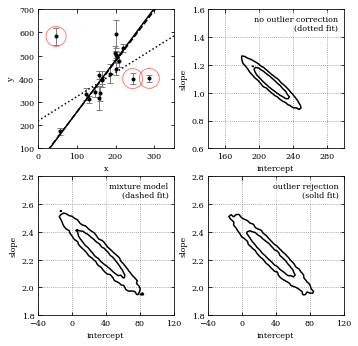

In [ ]:
# Author: Jake VanderPlas (adapted to PyMC3 by Brigitta Sipocz)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np

import pymc3 as pm

from matplotlib import pyplot as plt
from matplotlib import rc
rc('text', usetex=False) 
from theano import shared as tshared
import theano.tensor as tt

try:
  from astroML.datasets import fetch_hogg2010test
  from astroML.plotting.mcmc import convert_to_stdev
except ImportError:
  !pip install astroML
  from astroML.datasets import fetch_hogg2010test
  from astroML.plotting.mcmc import convert_to_stdev


# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#if "setup_text_plots" not in globals():
#    from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

np.random.seed(0)

# ------------------------------------------------------------
# Get data: this includes outliers. We need to convert them to Theano variables
data = fetch_hogg2010test()
xi = tshared(data['x'])
yi = tshared(data['y'])
dyi = tshared(data['sigma_y'])
size = len(data)


# ----------------------------------------------------------------------
# Define basic linear model

def model(xi, theta, intercept):
    slope = np.tan(theta)
    return slope * xi + intercept


# ----------------------------------------------------------------------
# First model: no outlier correction
with pm.Model():
    # set priors on model gradient and y-intercept
    inter = pm.Uniform('inter', -1000, 1000)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)

    y = pm.Normal('y', mu=model(xi, theta, inter), sd=dyi, observed=yi)

    trace0 = pm.sample(draws=10000, tune=2000)


# ----------------------------------------------------------------------
# Second model: nuisance variables correcting for outliers
# This is the mixture model given in equation 17 in Hogg et al
def mixture_likelihood(yi, xi):
    """Equation 17 of Hogg 2010"""

    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)

    Vi = dyi ** 2
    Vb = sigmab ** 2

    root2pi = np.sqrt(2 * np.pi)

    L_in = (1. / root2pi / dyi * np.exp(-0.5 * (yi - mu) ** 2 / Vi))

    L_out = (1. / root2pi / np.sqrt(Vi + Vb)
             * np.exp(-0.5 * (yi - Yb) ** 2 / (Vi + Vb)))

    return tt.sum(tt.log((1 - Pb) * L_in + Pb * L_out))


with pm.Model():
    # uniform prior on Pb, the fraction of bad points
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)

    # uniform prior on Yb, the centroid of the outlier distribution
    Yb = pm.Uniform('Yb', -10000, 10000, testval=0)

    # uniform prior on log(sigmab), the spread of the outlier distribution
    log_sigmab = pm.Uniform('log_sigmab', -10, 10, testval=5)

    inter = pm.Uniform('inter', -200, 400)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2, testval=np.pi / 4)

    y_mixture = pm.DensityDist('mixturenormal', logp=mixture_likelihood,
                               observed={'yi': yi, 'xi': xi})

    trace1 = pm.sample(draws=10000, tune=2000)


# ----------------------------------------------------------------------
# Third model: marginalizes over the probability that each point is an outlier.
# define priors on beta = (slope, intercept)

def outlier_likelihood(yi, xi):
    """likelihood for full outlier posterior"""

    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)

    Vi = dyi ** 2
    Vb = sigmab ** 2

    logL_in = -0.5 * tt.sum(qi * (np.log(2 * np.pi * Vi)
                                  + (yi - mu) ** 2 / Vi))

    logL_out = -0.5 * tt.sum((1 - qi) * (np.log(2 * np.pi * (Vi + Vb))
                                         + (yi - Yb) ** 2 / (Vi + Vb)))

    return logL_out + logL_in


with pm.Model():
    # uniform prior on Pb, the fraction of bad points
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)

    # uniform prior on Yb, the centroid of the outlier distribution
    Yb = pm.Uniform('Yb', -10000, 10000, testval=0)

    # uniform prior on log(sigmab), the spread of the outlier distribution
    log_sigmab = pm.Uniform('log_sigmab', -10, 10, testval=5)

    inter = pm.Uniform('inter', -1000, 1000)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)

    # qi is bernoulli distributed
    qi = pm.Bernoulli('qi', p=1 - Pb, shape=size)

    y_outlier = pm.DensityDist('outliernormal', logp=outlier_likelihood,
                               observed={'yi': yi, 'xi': xi})

    trace2 = pm.sample(draws=10000, tune=2000)


# ------------------------------------------------------------
# plot the data
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.1, top=0.95, hspace=0.2)

# first axes: plot the data
ax1 = fig.add_subplot(221)
ax1.errorbar(data['x'], data['y'], data['sigma_y'], fmt='.k', ecolor='gray', lw=1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

#------------------------------------------------------------
# Go through models; compute and plot likelihoods
linestyles = [':', '--', '-']
labels = ['no outlier correction\n(dotted fit)',
          'mixture model\n(dashed fit)',
          'outlier rejection\n(solid fit)']

x = np.linspace(0, 350, 10)

bins = [(np.linspace(140, 300, 51), np.linspace(0.6, 1.6, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51))]

for i, trace in enumerate([trace0, trace1, trace2]):
    H2D, bins1, bins2 = np.histogram2d(np.tan(trace['theta']),
                                       trace['inter'], bins=50)
    w = np.where(H2D == H2D.max())

    # choose the maximum posterior slope and intercept
    slope_best = bins1[w[0][0]]
    intercept_best = bins2[w[1][0]]

    # plot the best-fit line
    ax1.plot(x, intercept_best + slope_best * x, linestyles[i], c='k')

    # For the model which identifies bad points,
    # plot circles around points identified as outliers.
    if i == 2:
        Pi = trace['qi'].mean(0)
        outlier_x = data['x'][Pi < 0.32]
        outlier_y = data['y'][Pi < 0.32]
        ax1.scatter(outlier_x, outlier_y, lw=1, s=400, alpha=0.5,
                    facecolors='none', edgecolors='red')

    # plot the likelihood contours
    ax = plt.subplot(222 + i)

    H, xbins, ybins = np.histogram2d(trace['inter'],
                                     np.tan(trace['theta']), bins=bins[i])
    H[H == 0] = 1E-16
    Nsigma = convert_to_stdev(np.log(H))

    ax.contour(0.5 * (xbins[1:] + xbins[:-1]),
               0.5 * (ybins[1:] + ybins[:-1]),
               Nsigma.T, levels=[0.683, 0.955], colors='black')

    ax.set_xlabel('intercept')
    ax.set_ylabel('slope')
    ax.grid(color='gray')
    ax.xaxis.set_major_locator(plt.MultipleLocator(40))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))

    ax.text(0.96, 0.96, labels[i], ha='right', va='top',
            bbox=dict(fc='w', ec='none', alpha=0.5),
            transform=ax.transAxes)
    ax.set_xlim(bins[i][0][0], bins[i][0][-1])
    ax.set_ylim(bins[i][1][0], bins[i][1][-1])

ax1.set_xlim(0, 350)
ax1.set_ylim(100, 700)

plt.show()

## Gaussian mixture model to classify sources

Here we will put together an example of using a Gaussian mixture model to decompose observed colour-colour diagrams into different classes. To start with, we will grab some data from by extracting a subset of 1234 sources selected from Gaia DR2 with crossmatches in 2MASS.

In [ ]:
from astropy.table import Table

url = 'https://raw.githubusercontent.com/sundarjhu/DAWGI_Lectures_2021/main/'
file = 'Gaia_2MASS_phot_10000sample_data.vot'
t = Table.read(url + file, format = 'votable')

Now that we have this dataset and have extracted some colours, we can decompose this into classes. For starters, we use scikit-learn's implementation of Gaussian mixture models.

  gdr2_source_id        gdr2_ra       ... tmass_ks_mag tmass_ks_mag_err
                                      ...     mag            mag       
------------------ ------------------ ... ------------ ----------------
545638387657891840  41.19237701343396 ...       13.955            0.051
545642820064716800  43.23757227910512 ...       14.311            0.078
545606811058646784   41.7010555560097 ...       13.861               --
545666970664152576   43.1040777965382 ...       15.334            0.151
545529398568253696 41.235313520911404 ...       14.114            0.064
545561456204018688 42.103810289763324 ...       14.079            0.063
545587913202423296  39.90177398772654 ...       11.822            0.023
545622337364076544  41.07413667667716 ...       14.761            0.108
545580491499145728  41.25029513089197 ...       14.949            0.129
545592483047426816  39.70496551021806 ...       13.418            0.043
               ...                ... ...          ...          

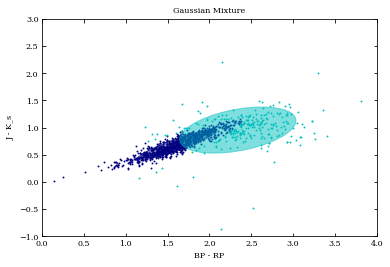

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture as GM



table.pprint()
print(table.colnames)

data1 = table['bp_rp'].data
d1_unc = np.sqrt(table['phot_bp_mean_mag_err'].data**2 + table['phot_rp_mean_mag_err'].data**2)
data2 = table['tmass_j_mag'].data - table['tmass_ks_mag'].data
d2_unc = np.sqrt(table['tmass_ks_mag_err'].data**2 + table['tmass_j_mag_err'].data**2)

print(np.nanmin(data1), np.nanmax(data1))
print(np.nanmin(data2), np.nanmax(data2))
data = np.vstack((data1, data2)).T
print(data.shape)
mask =np.logical_and( np.isfinite(data1), np.isfinite(data2))
gm = GM(n_components=2).fit(data[mask, :])

from scipy import linalg
import matplotlib as mpl
import itertools
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 1, 1)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(0., 4.)
    plt.ylim(-1., 3.)
    plt.xlabel("BP - RP")
    plt.ylabel("J - K_s")
    #plt.xticks(())
    #plt.yticks(())
    plt.title(title)

plot_results(data[mask], gm.predict(data[mask]), gm.means_, gm.covariances_, 0,
             'Gaussian Mixture')

We only tried to identify two classes, and it seems to reproduce the structure in this plot reasonably well. We have only compared two colours - [Bp - Rp] and [J - Ks]. However, there's nothing stopping us from turning this into an N-colour decomposition of the sources, using all 5 colours in this cross-match.



In [ ]:
data1 = table['bp_rp'].data
d1_unc = np.sqrt(table['phot_bp_mean_mag_err'].data**2 + table['phot_rp_mean_mag_err'].data**2)
data2 = table['phot_g_mean_mag'].data - table['phot_rp_mean_mag'].data
d2_unc = np.sqrt(table['phot_g_mean_mag_err'].data**2 + table['phot_rp_mean_mag_err'].data**2)
data3 
data2 = table['tmass_j_mag'].data - table['tmass_ks_mag'].data
d2_unc = np.sqrt(table['tmass_ks_mag_err'].data**2 + table['tmass_j_mag_err'].data**2)

print(np.nanmin(data1), np.nanmax(data1))
print(np.nanmin(data2), np.nanmax(data2))
data = np.vstack((data1, data2)).T
print(data.shape)

However, although sklearn is simple, it doesn't support uncertainty properly. We can try the same things with pyGMMis to use uncertainty on the colours. This is left as an exercise for the reader

In [ ]:
try:
  import pygmmis
except ImportError:
  !pip install pygmmis
  import pygmmis

gmm = pygmmis.GMM(K=2, D=5)      # K components, D dimensions

[what do we see]



What does this show?

So far, I have just arbitrarily assigned N classes to be fitted. But how many do we really need? Lets use BIC to try to find the minimum number of Gaussians required to explain the data.

In [ ]:
""" Copyright 2021 Peter Scicluna

Permission is hereby granted, free of charge, to any person obtaining a copy of 
this software and associated documentation files (the "Software"), to deal in 
the Software without restriction, including without limitation the rights to 
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of 
the Software, and to permit persons to whom the Software is furnished to do so, 
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all 
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR 
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS 
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR 
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER 
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE."""

' Copyright 2021 Peter Scicluna\n\nPermission is hereby granted, free of charge, to any person obtaining a copy of \nthis software and associated documentation files (the "Software"), to deal in \nthe Software without restriction, including without limitation the rights to \nuse, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of \nthe Software, and to permit persons to whom the Software is furnished to do so, \nsubject to the following conditions:\n\nThe above copyright notice and this permission notice shall be included in all \ncopies or substantial portions of the Software.\n\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR \nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS \nFOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR \nCOPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER \nIN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF